# VGGNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

## 1. 데이터 로드

In [2]:
# 구글드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_transformer = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()
])
test_transformer = transforms.Compose([transforms.ToTensor()])

BATCH_SIZE = 4
NUM_WORKERS = 2

drive_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/'
train_dataset = CIFAR10(root=drive_path, train=True, download=True, transform=train_transformer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print(train_dataset) # 5만개

test_dataset = CIFAR10(root=drive_path, train=False, download=True, transform=test_transformer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print(test_dataset) # 1만개

classes = train_dataset.classes # 10개
print(classes)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


train img shape:torch.Size([4, 3, 32, 32])
train img shape:torch.Size([3, 32, 32])


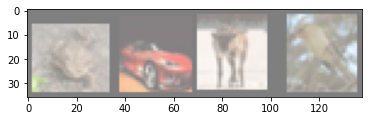

frog  automobile deer  bird 


In [4]:
# 이미지를 보여주는 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(f'train img shape:{images.shape}')
print(f'train img shape:{images[0].shape}')

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답 레이블 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

## 2. 모델 정의

In [ ]:
## layer 하나씩 쌓기

class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            # block5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layer = nn.Sequential(
            # nn.Linear(in_features=7*7*512, out_features=4096), # imagenet(3, 224, 224)
            nn.Linear(in_features=1*1*512, out_features=4096), # cifar(3, 32, 32)
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        # 일렬로 펴기
        x = x.view(x.size(0), -1)

        out = self.fc_layer(x)

        return out

In [12]:
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()

        self.layer1 = self.conv_2_block(3, 64)
        self.layer2 = self.conv_2_block(64, 128)
        self.layer3 = self.conv_4_block(128, 256)
        self.layer4 = self.conv_4_block(256, 512)
        self.layer5 = self.conv_4_block(512, 512)

        self.fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=4096), # cifar(3, 32, 32)
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def conv_2_block(self, in_ch, out_ch):
        layer = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return layer

    def conv_4_block(self, in_ch, out_ch):
        layer = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1) # 1줄로 펴기
        out = self.fc(out)

        return out

In [13]:
# GPU상에서 테스트
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

# input_img = torch.randn(size=(3, 32, 32), dtype=torch.float).to(device)
# print(f'input img shape: {input_img.shape}')

model = VGG19().to(device)
print(summary(model, (3, 32, 32)))

device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14      

## 3. 손실 함수와 optimizer 정의하기

In [14]:
net = VGG19()
net = net.to(device)

NUM_EPOCHS = 20

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 4. 신경망 학습하기

In [15]:
loss_list = []
acc_list = []

def train(epoch, loss_list, acc_list):
    print('\n [Train epoch: %d]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # (이미지, 정답 라벨)

        # gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()

        outputs = net(inputs) # 순전파
        loss = criterion(outputs, targets) # (모델 예측값, 정답)
        loss.backward() # 역전파
        optimizer.step() # 최적화

        # loss 출력
        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += targets.size(0)
        cur_correct = (preds == targets).sum().item() 
        correct += cur_correct

        if batch_idx % 1000 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', cur_correct / targets.size(0))
            print('Current batch average train loss:', loss.item() / targets.size(0))
    
    # 시각화 용도
    loss_list.append(loss.cpu().detach().numpy())
    acc_list.append(cur_correct / targets.size(0))

    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

In [16]:
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/딥러닝코딩/vgg19_ep20.pth'

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    val_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device) # (이미지, 정답 라벨)

        outputs = net(inputs) # 모델 예측값
        loss = criterion(outputs, targets) # (모델 예측값, 정답)

        # loss 출력
        val_loss += loss.item()
        _, preds = outputs.max(1)
        total += targets.size(0)
        cur_correct = (preds == targets).sum().item() 
        correct += cur_correct

    print('\nTotal average test accuarcy:', correct / total)
    print('Total average test loss:', loss / total)

    state = {
        'vgg19': net.state_dict()
    }
    # if not os.path.isdir('checkpoint'):
    #     os.mkdir('checkpoint')
    # torch.save(state, './checkpoint/' + file_name)
    torch.save(state, SAVE_PATH)
    print('Model Saved!')

In [ ]:
import time

def adjust_lr(optimizer, epoch):
    lr = LEARNING_RATE
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

start_time = time.time()

NUM_EPOCHS = 20
for epoch in range(0, NUM_EPOCHS):
    adjust_lr(optimizer, epoch)
    train(epoch, loss_list, acc_list)
    test(epoch)
    print('\nTime elapsed:', time.time() - start_time)


 [Train epoch: 0]

Current batch: 0
Current batch average train accuracy: 0.0
Current batch average train loss: 0.5770590305328369

Current batch: 1000
Current batch average train accuracy: 0.0
Current batch average train loss: 0.579138457775116

Current batch: 2000
Current batch average train accuracy: 0.0
Current batch average train loss: 0.5821332931518555

Current batch: 3000
Current batch average train accuracy: 0.25
Current batch average train loss: 0.561851978302002

Current batch: 4000
Current batch average train accuracy: 0.25
Current batch average train loss: 0.5465892553329468

Current batch: 5000
Current batch average train accuracy: 0.5
Current batch average train loss: 0.5575878024101257

Current batch: 6000
Current batch average train accuracy: 0.0
Current batch average train loss: 0.5875889658927917

Current batch: 7000
Current batch average train accuracy: 0.25
Current batch average train loss: 0.5753280520439148

Current batch: 8000
Current batch average train accura

## 5. 테스트하기

In [ ]:
## loss, acc 그래프
epochs = np.arange(1, NUM_EPOCHS+1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, loss_list)

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, acc_list)
plt.show()

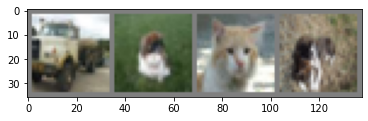

GroundTruth:  truck dog   cat   dog  


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

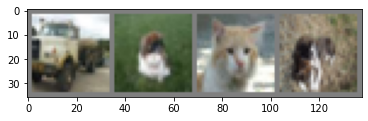

Predicted:  deer  deer  deer  deer 


In [ ]:
##  저장한 모델 로드해 테스트

net = VGG19().to(device)
net.load_state_dict(torch.load(SAVE_PATH)['vgg19'])

# 출력은 10개 분류 각가에 대한 값
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1) # 값이 가장 높은 클래스 하나 뽑기

imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [ ]:
correct = 0
total = 0

# 학습 중이 아니므로 gradient를 계산할 필요가 없음
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images) # 신경망에 이미지를 통과시켜 출력 계산
        _, preds = torch.max(outputs.data, 1) # 가장 큰 값을 가지는 클래스 뽑기
        total += labels.size(0) # 전체 테스트 데이터 개수
        correct += (preds == labels).sum().item() # 맞춘 데이터 개수

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
## 각 클래스별 예측값 계산

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        for label, pred in zip(labels, preds):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 0.0 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 100.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %
